GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
(10000, 96, 96, 3)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Partial FT Training...
Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.7159 - loss: 0.5459 - val_accuracy: 0.8155 - val_loss: 0.4097
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8390 - loss: 0.3625 - val_accuracy: 0.8240 - val_loss: 0.4028
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8214 - loss: 0.3975
Partial Test: [0.3931611180305481, 0.8259999752044678]
Whole FT Training...
Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 92ms/step - accuracy: 0.9073 - loss: 0.2358 - val_accuracy: 0.8540 - val_loss: 0.3597
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9596 - loss: 0.1198 - val_accuracy: 0.8640 - val_loss: 0.4073
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8607 - loss: 0.3871
Whole Test: [0.3893207311630249, 0.8615000247955322]


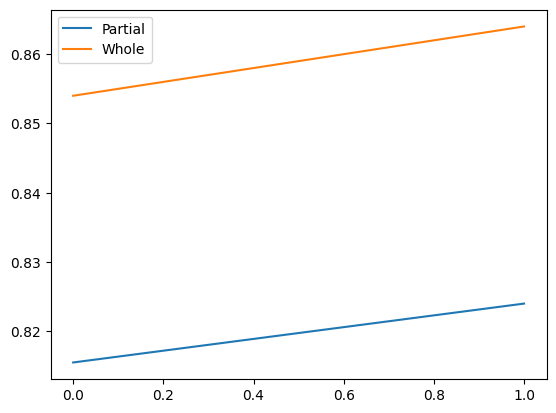

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

print("GPU:", tf.config.list_physical_devices('GPU'))

# ---------------- LOAD DATA ----------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

CAT, DOG = 3, 5

def filter_cat_dog(x, y):
    mask = np.where((y == CAT) | (y == DOG))[0]
    x = x[mask]
    y = y[mask]
    y = (y == DOG).astype("float32")
    return x, y

x_train, y_train = filter_cat_dog(x_train, y_train)
x_test, y_test   = filter_cat_dog(x_test, y_test)

# normalize
x_train = x_train / 255.0
x_test  = x_test / 255.0

# resize (light)
x_train = tf.image.resize(x_train, (96,96))
x_test  = tf.image.resize(x_test, (96,96))

print(x_train.shape)

# ---------------- MODEL ----------------
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(96,96,3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, output)

# ================= PARTIAL FT =================
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Partial FT Training...")
hist1 = model.fit(x_train, y_train,
                  validation_split=0.2,
                  epochs=2,
                  batch_size=16)

print("Partial Test:", model.evaluate(x_test, y_test))

# ================= WHOLE FT =================
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Whole FT Training...")
hist2 = model.fit(x_train, y_train,
                  validation_split=0.2,
                  epochs=2,
                  batch_size=16)

print("Whole Test:", model.evaluate(x_test, y_test))

# ---------------- PLOT ----------------
plt.plot(hist1.history['val_accuracy'], label="Partial")
plt.plot(hist2.history['val_accuracy'], label="Whole")
plt.legend()
plt.show()
